# [실습05] 합성곱 신경망(1)

## 201810909 컴퓨터과학과 김부용
https://github.com/KBY538/AITrack

### 0. library import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn # pytorch 제공, NN을 쉽게 구현할 수 있는 library
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import ipywidgets as widgets
from IPython.display import display

### 1. MNIST train, test dataset 가져오기

In [2]:
# "": 현재 폴더에 MNIST 있음
mnist_train = dset.MNIST("", train=True, transform=transforms.ToTensor(), #train 용도
                       target_transform=None, download=True)
mnist_test = dset.MNIST("", train=False, transform=transforms.ToTensor(), #test 용도
                       target_transform=None, download=True)

### 2. 대략적인 데이터 형태

mnist_train 길이:  60000
mnist_test 길이:  10000
image data shape:  torch.Size([1, 28, 28])
label:  5


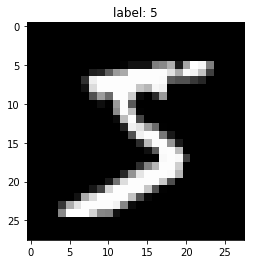

In [3]:
print "mnist_train 길이: ", len(mnist_train)
print "mnist_test 길이: ", len(mnist_test)

# 데이터 하나의 형태
image, label = mnist_train.__getitem__(0) # training set의 0번째 데이터
print "image data shape: ", image.size()
print "label: ", label

# 그리기
img = image.numpy() # image type을 그리기 위해 numpy로 변환 (1, 28, 28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap = 'gray')
plt.show()

#### MNIST data 띄워보기

5
torch.Size([1, 28, 28])
5


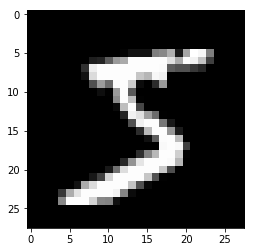

0


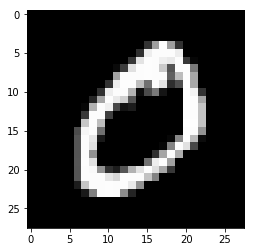

4


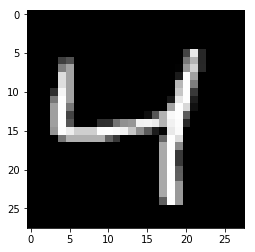

In [4]:
print(mnist_train[0][1]) #label
print(mnist_train[0][0].size()) #image

for i in range(3):
    img=mnist_train[i][0].numpy()
    print(mnist_train[i][1])
    plt.imshow(img[0], cmap='gray')
    plt.show()

#### convolution 하나 씌워보기

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


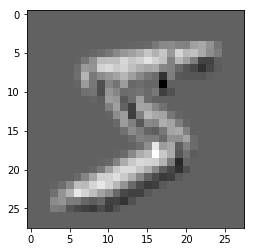

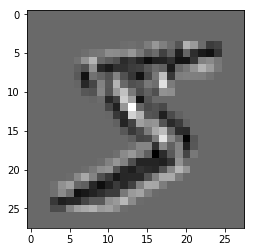

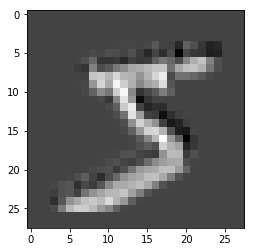

In [5]:
# mnist의 첫 번째 이미지, 라벨 가져오기
image, label = mnist_train[0]
# view: tensor의 사이즈 조절, -1: 해당 차원 하나 확장
# [1, 28, 28] -> [1, 1, 28, 28]
image=image.view(-1, image.size()[0], image.size()[1], image.size()[2])
print(image.size())

print label

# convolutional filter 정의
conv_layer=nn.Conv2d(in_channels=1,out_channels=3, kernel_size=3, padding=1)
# image에 filter 적용
output=conv_layer(Variable(image))
print(output.size())

for i in range(3):
    plt.imshow(output[0,i,:,:].data.numpy(), cmap='gray')
    plt.show()

### 3. CNN 만들기

#### train, test data 가져오기

In [6]:
batch_size = 16
learning_rate = 0.0002
num_epoch = 10

In [7]:
train_loader = torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], # mnist_train을 학습시킨다.
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          drop_last=True) # batch_size만큼 나눌 때 나머지는 버린다.
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                          shuffle=False, num_workers=2, # 관습적으로 test data는 shuffle하지 않는다.
                                          drop_last=True)

#### CNN 클래스 만들기 (모델 만들기)

![alt text](ex5Model.jpg)

In [8]:
class CNN(nn.Module): # nn.Module 상속받음
    def __init__(self):
        super(CNN, self).__init__() # 28 x 28
        self.layer=nn.Sequential(
            nn.Conv2d(1, 16, 5, padding=2),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, 5, padding=2), # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 28 x 28 -> 14 x 14
            
            nn.Conv2d(32, 64, 5, padding=2), # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #14 x 14 -> 7 x 7
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*7*7, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out
        
model = CNN()

In [9]:
# 파라미터 체크하기
for parameter in model.parameters():
    #print(parameter)
    print(parameter.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [10]:
# loss function, potimizer 선언
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 4. optimization

In [11]:
try:
    #미리 학습시킨 네트워크의 파라미터 로드
    model=torch.load('./nets/mycnn_model_10.pkl')
    print('model restored')
    m = True
except:
    print('model not restored')
    m = False

model restored


In [12]:
if not m:
    epoch = widgets.IntProgress(min=0, max=num_epoch,description='epoch:') # instantiate the bar
    display(epoch) # display the bar

    for i in range(num_epoch): # num_epoch만큼 학습
    
        epoch.value += 1 # signal to increment the progress bar
    
        for j, [imgs, labels] in enumerate(train_loader):
            x = Variable(imgs)
            y_ = Variable(labels)
        
            # 이후부터 학습 부분
            optimizer.zero_grad() # optimizer 안에서 이진 gradient들을 초기화
            output = model(x)
            loss = loss_func(output, y_)
            loss.backward() # back prop.
            optimizer.step() # parameter update
        
            if j%50==0:
                print("epoch: %d, batch index: %d.." %(i, j))
                print loss

### 5. 모델 저장

In [13]:
netname = './nets/mycnn_model_%d.pkl'%(num_epoch)
torch.save(model, netname)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 6. Accuracy 계산

In [14]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader): # batch_size 만큼
        img = Variable(imgs) # x
        label = Variable(labels) # y
        # label = Variable(labels)
        
        output = imodel.forward(img) # forward prop.
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [15]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 94.6200027466
